# Supervised learning models for predicting Credit Risk Analysis

### Notebook by [José David Rocha](https://github.com/davidrocha9), [Telmo Botelho](https://github.com/Telmo465)
#### Supported by [Luis Paulo Reis](https://web.fe.up.pt/~lpreis/)
#### [Faculdade de Engenharia da Universidade do Porto](https://sigarra.up.pt/feup/en/web_page.inicial)

#### It is recommended to [view this notebook in nbviewer]() for the best overall experience
#### You can also execute the code on this notebook using [Jupyter Notebook](https://jupyter.org/) or [Binder](https://mybinder.org/) (no local installation required)

## Table of contents

1. [Introduction](#Introduction)

2. [License](#License)

3. [Required libraries](#Required-libraries)

4. [The problem domain](#The-problem-domain)

5. [Step 1: Answering the question](#Step-1:-Answering-the-question)

6. [Step 2: Checking the Data](#Step-2:-Checking-the-data)

7. [Step 3: Classification](#Step-3:-Classification)

8. [Results Comparison](#Results-Comparison)

9. [Final Conclusions](#Final-Conclusions)

## Introduction

This project was developed using *Python* and *Jupyter Notebook/Lab* as its development environment during the 3<sup>rd</sup> year course Artificial Intelligence, part of the Integrated Master's Degree in Informatics and Computing Engineering in the Faculty of Engineering of the University of Porto. The main goal of this project is to build an efficient machine learning model that can determine whether a client will meet (or not) their debt obligations.

This notebook has the following structure:


[[ go back to the top ]](#Table-of-contents)

## Required libraries

[[ go back to the top ]](#Table-of-contents)

If you don't have Python on your computer, you can use the [Anaconda Python distribution](http://continuum.io/downloads) to install most of the Python packages you need. Anaconda provides a simple double-click installer for your convenience.

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
import numpy as np
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from IPython.display import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

## Step 2: Checking the data

[[ go back to the top ]](#Table-of-contents)

### Reading the Data

Let's start by reading the raw data from the provided *.csv* file. Since the *dataset* had more than 850 000 columns, we decided to only read the first 30000.

In [2]:
# Reading the data
read_data = pd.read_csv('data.csv', na_values=['NA'], low_memory=False, nrows=30000)
read_data.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

   int_rate  installment grade sub_grade  ... il_util open_rv_12m open_rv_24m  \
0     10.65       162.87     B        B2  ...     NaN         NaN         NaN   
1     15.27        59.83     C        C4  ...     NaN         NaN         NaN   
2     15.96        84.33     C        C5  ...     NaN         NaN         NaN   
3     13.49       339.31     C        C1  ...     NaN         NaN         NaN   
4     12.69        67.79     B        B5  ...     NaN         NaN         NaN   

   max_bal_bc all_util total_rev_hi_lim inq_fi total_cu_tl inq_last_12m  \
0         NaN      NaN              NaN    NaN         NaN          NaN   
1         NaN      NaN              NaN    NaN         NaN          NaN   
2         NaN      NaN              NaN    NaN         NaN          NaN   
3         NaN      NaN              NaN    NaN         NaN          NaN   
4         NaN      NaN              NaN    NaN         NaN          NaN   

  default_ind  
0           0  
1           1  
2           0  
3           0  
4           0  

[5 rows x 73 columns]

### Data Pre-Processing

It seems like the provided data has some problems that need to be solved before carrying out aditional analysis. With that in my mind, we identified the following issues:

#### Identified Problems

- Some columns have data that can be regarded as irrelevant for the prediciton, such as `id`, `member_id` and `emp_title`, since they provide information about parameters that don't have any value for building and testing an accurate model.
- There are some columns which have most of their values as *NaN* 
- It would be easier if columns such as `term` and `emp_length` contained only a single number, instead of a string.
    - Concerning `term`, instead of having values such as `36 months`, they could have just the value `36`.
    - Concerning `emp_length`, instead of having values such as `8 years`, they could have just the value `8`.
    - Concerning `grade` and `subgrade`, instead of having a score from A-G, they could simply have a number which represented their grade/subgrade.
    - Concerning `home_ownership`, the provided columns could have a single digit which represented the type of loan. For this dataset, we used 0 for `RENT`, 1 for `MORTGAGE`, 2 for `OWN`, 3 for `OTHER`, 4 for `NONE` and 5 for `ANY`.
- The provided data was unbalanced.


#### Solutions

We can start off by converting columns that can be converted to numerical values from categorical to numerical.

In [3]:
grade_dic = {'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5,
             'B1':11, 'B2':12, 'B3':13, 'B4':14, 'B5':15,
             'C1':21, 'C2':22, 'C3':23, 'C4':24, 'C5':25,
             'D1':31, 'D2':32, 'D3':33, 'D4':34, 'D5':35,
             'E1':41, 'E2':42, 'E3':43, 'E4':44, 'E5':45,
             'F1':51, 'F2':52, 'F3':53, 'F4':54, 'F5':55,
             'G1':61, 'G2':62, 'G3':63, 'G4':64, 'G5':65,
             'H1':71, 'H2':72, 'H3':73, 'H4':74, 'H5':75}

home_ownership_dic = {'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, "OTHER": 3, "NONE": 4, "ANY": 5}

read_data["sub_grade"].replace(grade_dic, inplace=True)
read_data["home_ownership"].replace(home_ownership_dic, inplace=True)
read_data['home_ownership'] = pd.to_numeric(read_data['home_ownership'])
read_data.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

   int_rate  installment grade  sub_grade  ... il_util open_rv_12m  \
0     10.65       162.87     B         12  ...     NaN         NaN   
1     15.27        59.83     C         24  ...     NaN         NaN   
2     15.96        84.33     C         25  ...     NaN         NaN   
3     13.49       339.31     C         21  ...     NaN         NaN   
4     12.69        67.79     B         15  ...     NaN         NaN   

   open_rv_24m  max_bal_bc all_util total_rev_hi_lim inq_fi total_cu_tl  \
0          NaN         NaN      NaN              NaN    NaN         NaN   
1          NaN         NaN      NaN              NaN    NaN         NaN   
2          NaN         NaN      NaN              NaN    NaN         NaN   
3          NaN         NaN      NaN              NaN    NaN         NaN   
4          NaN         NaN      NaN              NaN    NaN         NaN   

  inq_last_12m default_ind  
0          NaN           0  
1          NaN           1  
2          NaN           0  
3          NaN           0  
4          NaN           0  

[5 rows x 73 columns]

The second step on cleansing the data is to remove columns that contain irrelevant data, so that we can get rid of most of the data with `NaN` values as well as data that doesn't provide useful information for our prediction. We can do this by storing the columns to be removed in a list and then selecting the ones that are not on that list. We start by checking which columns have an unusual amout of `NaN` values and if so, we add them to the list of columns to ignore.

In [4]:
read_data.isnull().sum()

id                      0
member_id               0
loan_amnt               0
funded_amnt             0
funded_amnt_inv         0
                    ...  
total_rev_hi_lim    30000
inq_fi              30000
total_cu_tl         30000
inq_last_12m        30000
default_ind             0
Length: 73, dtype: int64

Furthermore, we will also add columns considered useless for our prediction (containing values such as id's and small descriptions) to the list of columns to ignore.

In [5]:
col_list = []
ignoredCols = ["id", "member_id", "emp_title", "desc", "grade",
               "mths_since_last_delinq", "mths_since_last_record",
               "initial_list_status", "mths_since_last_major_derog",
               "annual_inc_joint", "dti_joint", "verification_status_joint",
               "open_acc_6m", "open_il_6m", "open_il_12m", "open_il_24m",
               "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m",
               "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl",
               "inq_last_12m", "next_pymnt_d", "tot_coll_amt", "tot_cur_bal",
               "total_rev_hi_lim", "purpose", "title", "zip_code",
               "addr_state", "verification_status", "pymnt_plan",
               "last_pymnt_d", "last_credit_pull_d",
               "application_type", "collections_12_mths_ex_med", "acc_now_delinq",
               "policy_code", "issue_d", "earliest_cr_line"]

for key in read_data.keys():
    if key not in ignoredCols:
        col_list.append(key)

read_data = read_data[col_list]
read_data.head()

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0       5000         5000           4975.0   36 months     10.65       162.87   
1       2500         2500           2500.0   60 months     15.27        59.83   
2       2400         2400           2400.0   36 months     15.96        84.33   
3      10000        10000          10000.0   36 months     13.49       339.31   
4       3000         3000           3000.0   60 months     12.69        67.79   

   sub_grade emp_length  home_ownership  annual_inc  ...  out_prncp_inv  \
0         12  10+ years               0     24000.0  ...            0.0   
1         24   < 1 year               0     30000.0  ...            0.0   
2         25  10+ years               0     12252.0  ...            0.0   
3         21  10+ years               0     49200.0  ...            0.0   
4         15     1 year               0     80000.0  ...          766.9   

    total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
0   5861.071414          5831.78          5000.00         861.07   
1   1008.710000          1008.71           456.46         435.17   
2   3003.653644          3003.65          2400.00         603.65   
3  12226.302210         12226.30         10000.00        2209.33   
4   3242.170000          3242.17          2233.10        1009.07   

   total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_amnt  \
0                0.00        0.00                     0.00           171.62   
1                0.00      117.08                     1.11           119.66   
2                0.00        0.00                     0.00           649.91   
3               16.97        0.00                     0.00           357.48   
4                0.00        0.00                     0.00            67.79   

   default_ind  
0            0  
1            1  
2            0  
3            0  
4            0  

[5 rows x 29 columns]

The next step we need to take is to convert data which could be represented by single values from strings to numbers.

In [6]:
mode=read_data['term'].mode()
read_data['term'].replace('[^0-9]',"",inplace=True,regex=True)
read_data['term']=read_data['term'].fillna(10)
convert_dict = {'term': int} 
read_data= read_data.astype(convert_dict)

# Cleaning emp_length
mode=read_data['emp_length'].mode()
read_data['emp_length'].replace('[^0-9]',"",inplace=True,regex=True)
read_data['emp_length']=read_data['emp_length'].fillna(10)
convert_dict = {'emp_length': int} 
read_data= read_data.astype(convert_dict)

read_data.dropna()
read_data.head()

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0       5000         5000           4975.0    36     10.65       162.87   
1       2500         2500           2500.0    60     15.27        59.83   
2       2400         2400           2400.0    36     15.96        84.33   
3      10000        10000          10000.0    36     13.49       339.31   
4       3000         3000           3000.0    60     12.69        67.79   

   sub_grade  emp_length  home_ownership  annual_inc  ...  out_prncp_inv  \
0         12          10               0     24000.0  ...            0.0   
1         24           1               0     30000.0  ...            0.0   
2         25          10               0     12252.0  ...            0.0   
3         21          10               0     49200.0  ...            0.0   
4         15           1               0     80000.0  ...          766.9   

    total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
0   5861.071414          5831.78          5000.00         861.07   
1   1008.710000          1008.71           456.46         435.17   
2   3003.653644          3003.65          2400.00         603.65   
3  12226.302210         12226.30         10000.00        2209.33   
4   3242.170000          3242.17          2233.10        1009.07   

   total_rec_late_fee  recoveries  collection_recovery_fee  last_pymnt_amnt  \
0                0.00        0.00                     0.00           171.62   
1                0.00      117.08                     1.11           119.66   
2                0.00        0.00                     0.00           649.91   
3               16.97        0.00                     0.00           357.48   
4                0.00        0.00                     0.00            67.79   

   default_ind  
0            0  
1            1  
2            0  
3            0  
4            0  

[5 rows x 29 columns]

We now have a usable set of data! Let's now check for multi-colinear features. Having independent variables highly correlated together would impact the performance of our model, since they provide the same information.

Independent variables that are highly correlated together cannot be placed in the same model because they provide the same information. That said, we will be using a correlation matrix in order to detect these variables.

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5]),
 [Text(0, 0.5, 'loan_amnt'),
  Text(0, 2.5, 'funded_amnt_inv'),
  Text(0, 4.5, 'int_rate'),
  Text(0, 6.5, 'sub_grade'),
  Text(0, 8.5, 'home_ownership'),
  Text(0, 10.5, 'dti'),
  Text(0, 12.5, 'inq_last_6mths'),
  Text(0, 14.5, 'pub_rec'),
  Text(0, 16.5, 'revol_util'),
  Text(0, 18.5, 'out_prncp'),
  Text(0, 20.5, 'total_pymnt'),
  Text(0, 22.5, 'total_rec_prncp'),
  Text(0, 24.5, 'total_rec_late_fee'),
  Text(0, 26.5, 'collection_recovery_fee'),
  Text(0, 28.5, 'default_ind')])

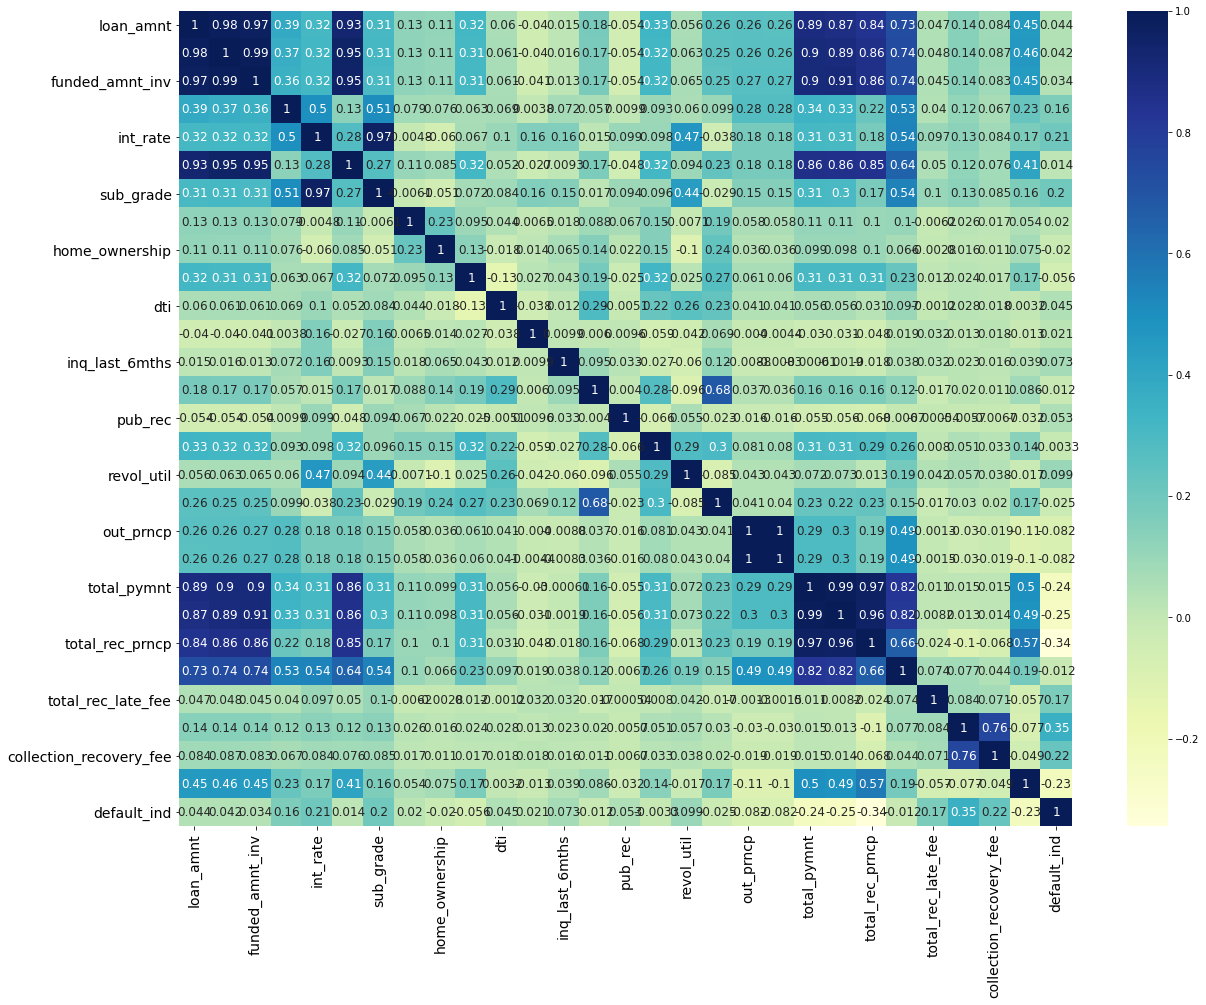

In [7]:
corr_matrix = read_data.corr()
heatMap=sb.heatmap(corr_matrix, annot=True,  cmap="YlGnBu", annot_kws={'size':12})
heatmap=plt.gcf()
heatmap.set_size_inches(20,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

By analysing the result matrix, we can conclude that some parameters are multicolinear:

- `loan_amt`, `funded_amnt` and `funded_amnt_inv`
- `out_prncp` and `out_prncp_inv`
- `total_pymnt`, `total_pymnt_inv` and `total_rec_prncp`

We will add these multicolinear columns to the list of colums to drop, so that we can update the Dataframe.

In [8]:
col_list = []

ignoredCols = ["funded_amnt", "funded_amnt_inv", "out_prncp_inv",
               "total_pymnt_inv", "total_rec_prncp"]

for key in read_data.keys():
    if key not in ignoredCols:
        col_list.append(key)

read_data = read_data[col_list]
read_data.dropna(how='any', inplace=True)
read_data.head()

loan_amnt  term  int_rate  installment  sub_grade  emp_length  \
0       5000    36     10.65       162.87         12          10   
1       2500    60     15.27        59.83         24           1   
2       2400    36     15.96        84.33         25          10   
3      10000    36     13.49       339.31         21          10   
4       3000    60     12.69        67.79         15           1   

   home_ownership  annual_inc    dti  delinq_2yrs  ...  revol_util  total_acc  \
0               0     24000.0  27.65            0  ...        83.7          9   
1               0     30000.0   1.00            0  ...         9.4          4   
2               0     12252.0   8.72            0  ...        98.5         10   
3               0     49200.0  20.00            0  ...        21.0         37   
4               0     80000.0  17.94            0  ...        53.9         38   

   out_prncp   total_pymnt  total_rec_int  total_rec_late_fee  recoveries  \
0        0.0   5861.071414         861.07                0.00        0.00   
1        0.0   1008.710000         435.17                0.00      117.08   
2        0.0   3003.653644         603.65                0.00        0.00   
3        0.0  12226.302210        2209.33               16.97        0.00   
4      766.9   3242.170000        1009.07                0.00        0.00   

   collection_recovery_fee  last_pymnt_amnt  default_ind  
0                     0.00           171.62            0  
1                     1.11           119.66            1  
2                     0.00           649.91            0  
3                     0.00           357.48            0  
4                     0.00            67.79            0  

[5 rows x 24 columns]

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5]),
 [Text(0, 0.5, 'loan_amnt'),
  Text(0, 2.5, 'int_rate'),
  Text(0, 4.5, 'sub_grade'),
  Text(0, 6.5, 'home_ownership'),
  Text(0, 8.5, 'dti'),
  Text(0, 10.5, 'inq_last_6mths'),
  Text(0, 12.5, 'pub_rec'),
  Text(0, 14.5, 'revol_util'),
  Text(0, 16.5, 'out_prncp'),
  Text(0, 18.5, 'total_rec_int'),
  Text(0, 20.5, 'recoveries'),
  Text(0, 22.5, 'last_pymnt_amnt')])

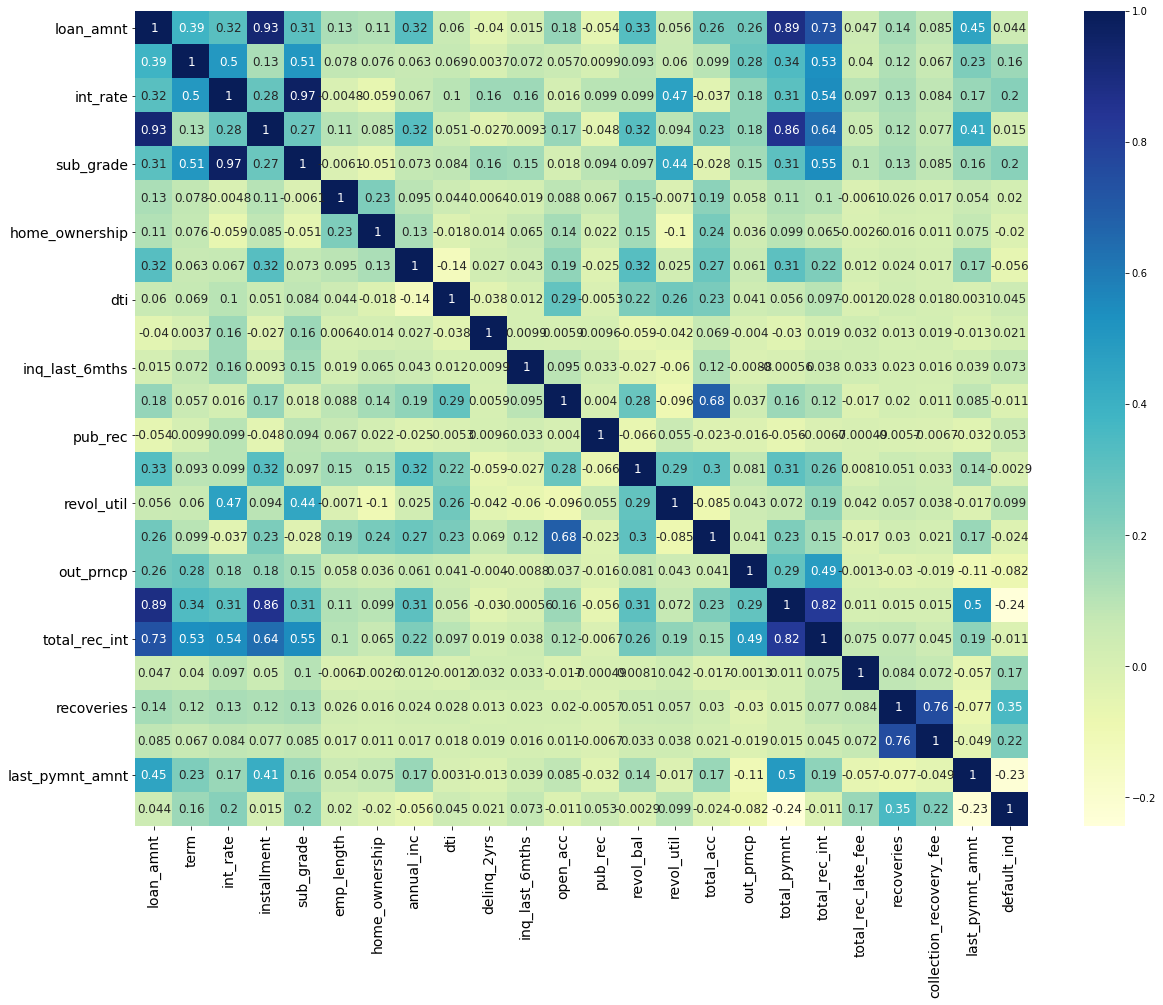

In [9]:
corr_matrix = read_data.corr()
heatMap=sb.heatmap(corr_matrix, annot=True,  cmap="YlGnBu", annot_kws={'size':12})
heatmap=plt.gcf()
heatmap.set_size_inches(20,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

The next step is to check for the existence of outliers and remove them in case there is any. In order to do this, let's start by plotting a graph so we can better visualize the data. Visualization makes outliers and errors immediately stand out, whereas they might go unnoticed in a large table of numbers. To plot this graph we will be using a **scatter_matrix**, which uses as dimensions the most important features of our problem.

In [10]:
fig = px.scatter_matrix(read_data, dimensions=
['loan_amnt', 'sub_grade', 'annual_inc', 'installment', 'term', 'emp_length'],
labels={col:col.replace('_', ' ') for col in read_data.columns},           
height=900, color="default_ind", color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

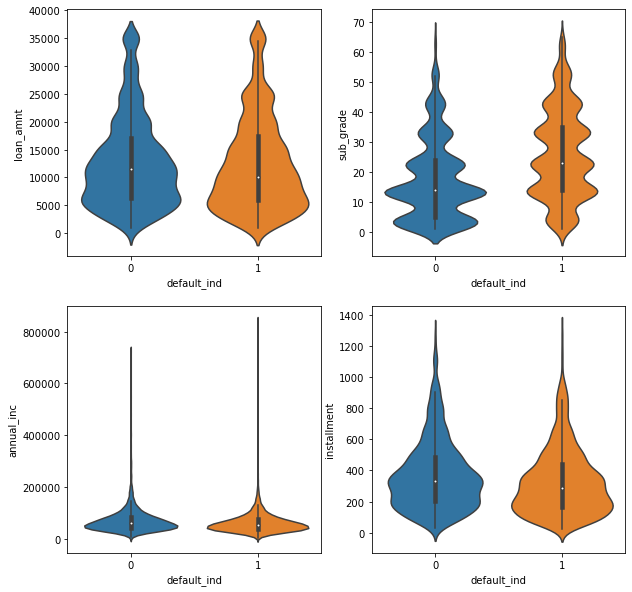

In [11]:
Image(filename='images/violin_plot.png')

It looks like we have some issues when it comes to `annual_inc`. Most of the loanees from this *dataset* earn up to to 1M/1.5M dollars, however there are two loanees that earn around 2M dollars and one who earns around 4M dollars. Taking that into account, we'll only consider loanees who earn up to 2M dollars.

In [12]:
read_data = read_data[read_data["annual_inc"]<=2000000] 

The last step on pre-processing the data is to check for **data imbalance**. Since the purpose of our model is to predict whether a client will fail to meet their payment obligations (meaning their `default_ind` has the value of 1) or not (meaning their `default_ind` has the value of 0), we needed to make sure our dataset had a similar amount of clients in both situations.

<AxesSubplot:>

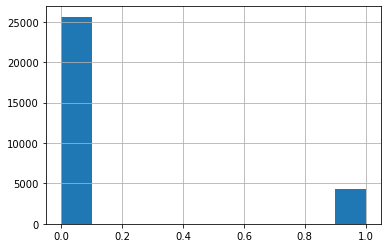

In [13]:
read_data['default_ind'].hist()

It is clear that there is a significant difference between clients with a `default_ind` of 0 and clients with a `default_ind` of 1. In order to solve this issue, we will reduce the amount of data of clients with a `default_ind` of 0, which allows for the *dataset* to be more balanced. In other words, we undersample the data from the majority class, and since we have such a large amount of data, we don't need to worry about not having enough data.

In [14]:
read_data.dropna()
read_data.dropna(how='any', inplace=True)

default_data = read_data.loc[read_data['default_ind'] == 1]
default_data.dropna()
LIMIT = len(default_data)
non_default_data = read_data.loc[read_data['default_ind'] == 0]
non_default_data.dropna()
non_default_data = non_default_data[:LIMIT]

read_data = pd.concat([default_data, non_default_data])

Great! We have now finished pre-processing and cleaning our *dataset*! Let's move onto the next step: **Classification**.

In [15]:
read_data.count()

loan_amnt                  8702
term                       8702
int_rate                   8702
installment                8702
sub_grade                  8702
emp_length                 8702
home_ownership             8702
annual_inc                 8702
dti                        8702
delinq_2yrs                8702
inq_last_6mths             8702
open_acc                   8702
pub_rec                    8702
revol_bal                  8702
revol_util                 8702
total_acc                  8702
out_prncp                  8702
total_pymnt                8702
total_rec_int              8702
total_rec_late_fee         8702
recoveries                 8702
collection_recovery_fee    8702
last_pymnt_amnt            8702
default_ind                8702
dtype: int64

## Step 3: Classification

[[ go back to the top ]](#Table-of-contents)

Now that our data has been properly extracted and handled to fit our needs, we can now proceed to using them for training and testing of all algorithms implemented.

We settled for the following approach:
- Defining the Classifier
- Defining the Parameter Sets
- Using *GridSearchCV* in order to find the best score

First off all, we need to split our *dataset* into a **training set** and a **testing set**. For this, we will use 75% of the data for training purposes and 25% of the data for testing purposes.

In [16]:
all_inputs = read_data.drop(columns=["default_ind"])
all_labels = read_data['default_ind'].values

X_train, X_test, y_train, y_test = train_test_split(all_inputs, all_labels, test_size=0.25)

We will also need to standardize our data. If we don't do this, some estimators might behave differently from expected - this happens when the individual features do not fit the standard distributed data. If we do not do this, we can end up with worse results, hence why it is important to use the same coefficients for both training and testing data. 

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

We will be using *Cross-Validation* for all implemented algorithms, since this is a useful method in order to ensure the class proportions are equal across all of the folds. This is necessary for maintaining a balanced subset that is representative of our *dataset*. Furthermore, we also predicted the values for training and testing data, so we could avoid/detect possible *overfitting*. We do this by checking whether both scores are similar - if not, it means our model is *overfitting* the training data.

In [18]:
cross_validation = StratifiedKFold(n_splits=10)

best_scores = {}
classifiers = {}
training_times = {}

Our aim for each algorithm is to find the best combination from a set of several different parameters, so that we can get the best from the `accuracy` score.

Great! We are now ready to start implementing the algorithms!

### Decision Trees

Decision Trees learning divides the *dataset* into *subsets*, based on the variable that best discriminates the data available.
This same procedure is then applied recursively to each of the *subsets* until all the members of a *subset* belong to a single class.

Best score: 0.9777828145698475
Best parameters: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 12}
              precision    recall  f1-score   support

        PAID       1.00      1.00      1.00      3281
   DEFAULTED       1.00      1.00      1.00      3245

    accuracy                           1.00      6526
   macro avg       1.00      1.00      1.00      6526
weighted avg       1.00      1.00      1.00      6526

              precision    recall  f1-score   support

        PAID       0.96      0.96      0.96      1070
   DEFAULTED       0.96      0.96      0.96      1106

    accuracy                           0.96      2176
   macro avg       0.96      0.96      0.96      2176
weighted avg       0.96      0.96      0.96      2176

Training accuracy:  1.0
Testing accuracy:  0.9590992647058824
[0.97818599 0.97818599 0.98390805 0.98965517 0.98390805 0.96781609
 0.97126437 0.97931034 0.97701149 0.97931034]


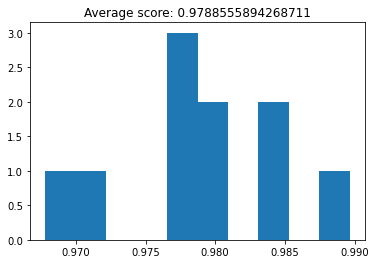

In [19]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [ 2, 3, 4, 5, 10, 20, 30, 40, 50],
              'max_features': [1, 2, 3, 4, 6, 8, 12]
              }
    
grid_search = GridSearchCV(decision_tree_classifier,
                           parameter_grid,
                           scoring='accuracy',
                           cv=cross_validation)

grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


decision_tree_classifier = grid_search.best_estimator_
   
predictions_train = grid_search.predict(X_train)
predictions_test = grid_search.predict(X_test)

print(classification_report(y_train, predictions_train, target_names=['PAID', 'DEFAULTED']))
print(classification_report(y_test, predictions_test, target_names=['PAID', 'DEFAULTED']))

print("Training accuracy: ", accuracy_score(y_train, predictions_train))
print("Testing accuracy: ", accuracy_score(y_test, predictions_test))

cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=cross_validation, scoring="accuracy")
print(cv_scores)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

classifiers['DecisionTree'] = grid_search.best_estimator_
best_scores['DecisionTree'] = grid_search.best_score_
training_times['DecisionTree'] = grid_search.cv_results_['mean_fit_time']

This model allowed us to achieve a score of 0.978, which is already very good and sets a good comparison parameter for the algorithms to come.

### K-Nearest Neighbors

The K-Nearest Neighbors algorithm is an approach to data classification that estimates how likely a data point is to be a member of one group or the other depending on what group the data points nearest to it are in. It iterates over each example in the data, calculates the distance between the object to be classified and the iterated examples, and then picks the $ K $ closest neighbors. From these $ K $  neighbors, it then returns the mode of the values to classify the object.

The K-Nearest Neighbors is an example of a "lazy learner" algorithm, meaning that it does not build a model using the training set until a query of the data set is performed.

To determine the best value for $ K $ for our data set, we run the algorithm several times, choosing the value that minimizes the errors encountered.

Best score: 0.8646966807279286
Best parameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        PAID       1.00      1.00      1.00      3281
   DEFAULTED       1.00      1.00      1.00      3245

    accuracy                           1.00      6526
   macro avg       1.00      1.00      1.00      6526
weighted avg       1.00      1.00      1.00      6526

              precision    recall  f1-score   support

        PAID       0.82      0.92      0.87      1070
   DEFAULTED       0.91      0.81      0.86      1106

    accuracy                           0.86      2176
   macro avg       0.87      0.86      0.86      2176
weighted avg       0.87      0.86      0.86      2176

Training accuracy:  1.0
Testing accuracy:  0.8630514705882353
[0.88633754 0.87485649 0.87356322 0.90114943 0.90574713 0.87011494
 0.83793103 0.87126437 0.84597701 0.85747126]


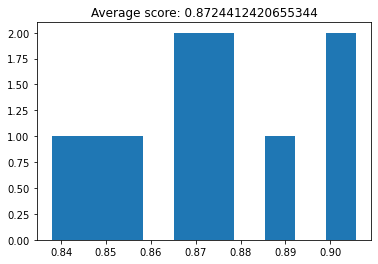

In [20]:
knn_classifier = KNeighborsClassifier()

parameter_grid = {
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'n_neighbors' : [2, 4, 6, 8, 10],
    'leaf_size' : [10, 20, 30, 40, 50],
    'p': [1,2]
}

grid_search = GridSearchCV(knn_classifier, 
                    parameter_grid,
                    scoring='accuracy',
                    n_jobs=-1,
                    cv=cross_validation)


grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

predictions_train = grid_search.predict(X_train)
predictions_test = grid_search.predict(X_test)

print(classification_report(y_train, predictions_train, target_names=['PAID', 'DEFAULTED']))
print(classification_report(y_test, predictions_test, target_names=['PAID', 'DEFAULTED']))

print("Training accuracy: ", accuracy_score(y_train, predictions_train))
print("Testing accuracy: ", accuracy_score(y_test, predictions_test))

cv_scores = cross_val_score(knn_classifier, all_inputs, all_labels, cv=cross_validation, scoring="accuracy")
print(cv_scores)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

classifiers['K-Nearest Neighbors'] = grid_search.best_estimator_
best_scores['K-Nearest Neighbors'] = grid_search.best_score_
training_times['K-Nearest Neighbors'] = grid_search.cv_results_['mean_fit_time']

This model achieved a score of 0.867, which allows us to say that the KNN Algorithm underperformed in comparison to the Decision Trees Algorithm. Nonetheless, this algorithm is fairly simple, versatile and easy to implement, which makes it useful in some situations. However, in this context, this is not case.

By analyzing the `classification_report` of the training and testing results we can see that both results are slightly different, which means this model has a tendency to overfit the training data.

### Support Vector Machines

Given a set of training examples, each marked as belonging to one of two categories, an **SVM** training algorithm builds a model that assigns new examples to one category or the other. **SVM** maps training examples to points in space so as to maximize the width of the gap between the two categories. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

Best score: 0.9932571707738707
Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
              precision    recall  f1-score   support

        PAID       0.99      1.00      0.99      3281
   DEFAULTED       1.00      0.99      0.99      3245

    accuracy                           0.99      6526
   macro avg       0.99      0.99      0.99      6526
weighted avg       0.99      0.99      0.99      6526

              precision    recall  f1-score   support

        PAID       0.97      1.00      0.98      1070
   DEFAULTED       1.00      0.97      0.98      1106

    accuracy                           0.98      2176
   macro avg       0.98      0.98      0.98      2176
weighted avg       0.98      0.98      0.98      2176

Training accuracy:  0.9941771376034324
Testing accuracy:  0.9834558823529411
[0.94374282 0.93455798 0.95057471 0.94712644 0.93678161 0.91494253
 0.91494253 0.9183908  0.89310345 0.91724138]


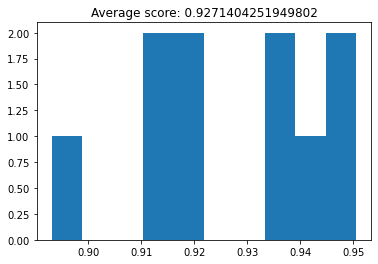

In [21]:
svm_classifier = SVC(random_state=1)

parameters = [{'kernel': ['rbf', 'linear'], 'gamma': [1e-3, 1e-4], 'C': [0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(svm_classifier,
                    parameters,
                    n_jobs=4,
                    scoring='accuracy',
                    cv=cross_validation)

grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

predictions_train = grid_search.predict(X_train)
predictions_test = grid_search.predict(X_test)

print(classification_report(y_train, predictions_train, target_names=['PAID', 'DEFAULTED']))
print(classification_report(y_test, predictions_test, target_names=['PAID', 'DEFAULTED']))

print("Training accuracy: ", accuracy_score(y_train, predictions_train))
print("Testing accuracy: ", accuracy_score(y_test, predictions_test))

cv_scores = cross_val_score(svm_classifier, all_inputs, all_labels, cv=cross_validation, scoring="accuracy")
print(cv_scores)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

classifiers['Support Vector Machines'] = grid_search.best_estimator_
best_scores['Support Vector Machines'] = grid_search.best_score_
training_times['Support Vector Machines'] = grid_search.cv_results_['mean_fit_time']

The **SVM** model allowed us to achieve a score of 0.993, which is the highest score recorded so far. Its behavior was significantly better compared to **KNN**, as already expected, and slightly better than the one from **Decision Trees**.

By analyzing the `classification_report` of the training and testing results we can see that both results are fairly similar, which means this model is not overfitting the training data.

### Neural Networks

Best score: 0.992032290795667
Best parameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (32,), 'learning_rate': 'constant', 'solver': 'adam'}
              precision    recall  f1-score   support

        PAID       0.99      1.00      1.00      3281
   DEFAULTED       1.00      0.99      1.00      3245

    accuracy                           1.00      6526
   macro avg       1.00      1.00      1.00      6526
weighted avg       1.00      1.00      1.00      6526

              precision    recall  f1-score   support

        PAID       0.97      1.00      0.99      1070
   DEFAULTED       1.00      0.97      0.99      1106

    accuracy                           0.99      2176
   macro avg       0.99      0.99      0.99      2176
weighted avg       0.99      0.99      0.99      2176

Training accuracy:  0.9954030033711309
Testing accuracy:  0.9857536764705882
[0.97588978 0.96211251 0.98390805 0.97931034 0.97241379 0.83908046
 0.93448276 0.97356322 0.97126437 0

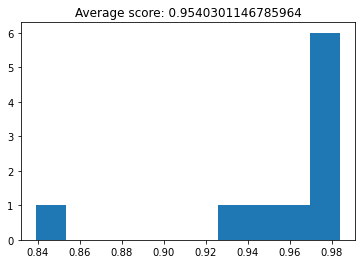

In [22]:
mlp_classifier = MLPClassifier(random_state=1, max_iter=2000)


tuned_parameters = {'hidden_layer_sizes': [(32,), (64,)],
                    'activation': ['logistic','tanh'],
                    'solver': ['adam', 'sgd'], #'lbfgs'
                    'alpha': [0.0001, 0.05],
                    'learning_rate': ['constant','adaptive']}

grid_search = GridSearchCV(mlp_classifier, 
                    tuned_parameters,
                    scoring='accuracy',
                    n_jobs=-1,
                    cv=cross_validation)

grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

predictions_train = grid_search.predict(X_train)
predictions_test = grid_search.predict(X_test)

print(classification_report(y_train, predictions_train, target_names=['PAID', 'DEFAULTED']))
print(classification_report(y_test, predictions_test, target_names=['PAID', 'DEFAULTED']))

print("Training accuracy: ", accuracy_score(y_train, predictions_train))
print("Testing accuracy: ", accuracy_score(y_test, predictions_test))

cv_scores = cross_val_score(mlp_classifier, all_inputs, all_labels, cv=cross_validation, scoring="accuracy")
print(cv_scores)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

classifiers['Neural Networks'] = grid_search.best_estimator_
best_scores['Neural Networks'] = grid_search.best_score_
training_times['Neural Networks'] = grid_search.cv_results_['mean_fit_time']

This model allowed us to achieve a score of 0.991, which is on par with the rest of the results from the other implemented algorithms. It is by far the most complex algorithm, which why it took much more time to process in comparison to the rest of the algorithms.

By analyzing the `classification_report` of the training and testing results we can see that both results are fairly similar, which means this model is not overfitting the training data.

## Results Comparison

[[ go back to the top ]](#Table-of-contents)

Since we now have the best scores from all four classifiers, let's compare them and make some final conclusions regarding these.

[Text(0, 0, 'DecisionTree'),
 Text(1, 0, 'K-Nearest Neighbors'),
 Text(2, 0, 'Support Vector Machines'),
 Text(3, 0, 'Neural Networks')]

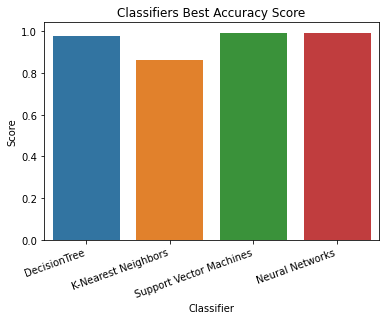

In [23]:
score_df = pd.DataFrame()
for name, score in best_scores.items():
    score_df = score_df.append(pd.DataFrame({'Score': [score], 'Classifier': [name]}))

ax = sb.barplot(x='Classifier', y='Score', data=score_df)
ax.set_title('Classifiers Best Accuracy Score')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')  

We can see that all algorithms were able to reach a good result - K-Nearest Neighbors' was slighly lower than the rest of the algorithms but, nonetheless, it was still decent. We already expected this due to the nature and reduced complexity of this algorithm in comparison to the others. **SVM** and **Neural Networks** were the best performing models, with **SVM** being slighty better. However, we expected **Neural Networks** to be the best scoring model, followed by **SVM** and **Decision Trees**. This is probably due to the fact that the input data fed to both of these algorithms is more suitable for **SVM** than for **Neural Networks**. If we had higher computational power and were able to make predictions using higher amounts of data, **Neural Networks** would probably surpass **SVM** in terms of score. Nonetheless, these algorithms had an excellent performance.  

[Text(0, 0, 'DecisionTree'),
 Text(1, 0, 'K-Nearest Neighbors'),
 Text(2, 0, 'Support Vector Machines'),
 Text(3, 0, 'Neural Networks')]

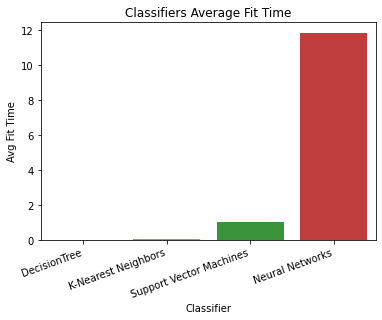

In [24]:
import numpy as np
fittime_df = pd.DataFrame()
for name, fittime in training_times.items():
    fittime = np.mean(fittime)
    fittime_df = fittime_df.append(pd.DataFrame({'Avg Fit Time': [fittime], 'Classifier': [name]}))
    
ax = sb.barplot(x='Classifier', y='Avg Fit Time', data=fittime_df)
ax.set_title('Classifiers Average Fit Time')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

When it comes to the time each algorithm spent on its training, we can see that **Neural Networks** took much more time than the rest of the algorithms to perform its training. We already expected this, since this specific algorithm is much more complex in comparison to the rest of the algorithms.

[Text(0, 0, 'DecisionTree'),
 Text(1, 0, 'K-Nearest Neighbors'),
 Text(2, 0, 'Support Vector Machines'),
 Text(3, 0, 'Neural Networks')]

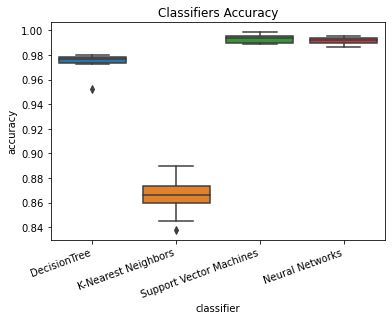

In [25]:
clf_df = pd.DataFrame()
for name, clf in classifiers.items():
    clf_df = clf_df.append(pd.DataFrame({'accuracy': cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=10)),
                       'classifier': [name] * 10}))

ax = sb.boxplot(x='classifier', y='accuracy', data=clf_df)
ax.set_title('Classifiers Accuracy')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')

By analyzing all of the classification reports, we can assume that all models have a high sucess rate when it comes to predicting credit risk, expect of course for **K-Nearest Neighbors**, which had a good sucess rate, of about 10% less compared to the rest of the algorithms.

On the whole, we concluded that **Support Vector Machines** is the best fit for our data. We already expected **Support Vector Machines** and **Neural Networks** to be the best peforming models, but we were more inclined to say **Neural Networks** would be the best, not only because of being a more complex algorithm but also because of the very large data we have available.
On the other hand, we also expected **K-Nearest Neighbors** to underperform in comparison to the other algorithms. This is due to it being a lazy algorithm, that does not need any training data points for model generation.

## Final Conclusions

[[ go back to the top ]](#Table-of-contents)

On the whole, this project allowed us to work with various Machine Learning models concerning Supervised Learning. It was also an eye opener when it comes to the usefulness of machine learning and how powerful it can be on our daily lives. It is very interesting and quite interesting how we can make some complex decisions based only on feeding data to several Supervised Learning models.

We also realized that it was much more important to have a consistent and clean set of data than to have a good implementation of the several Models. In other words, a good Model will never make up for bad, unclean data.

Overall, this project granted us the opportunity to understand how useful Data Science and Machine Learning can be on such sensitive topics, such as Credit Risk Analysis, which, in this cases, dictates how profitable a business can be. 

---

# References

- [Credit Risk Modeling with Machine Learning](https://towardsdatascience.com/credit-risk-modeling-with-machine-learning-8c8a2657b4c4)
- [Credit Risk Modelling in Python](https://medium.com/analytics-vidhya/credit-risk-modelling-in-python-3ab4b00f6505)
- [A Machine Learning Approach To Credit Risk Assessment](https://towardsdatascience.com/a-machine-learning-approach-to-credit-risk-assessment-ba8eda1cd11f)
- [Credit Risk Analysis](https://www.kaggle.com/karanagarwal/credit-risk-analysis)
- [Credit Risk Modeling Case Study](https://www.kaggle.com/yashmd/dimensionless-coding-round-1-yash-mahadeshwar)
- [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree)
- [K-Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
- [Support-vector Machine](https://en.wikipedia.org/wiki/Support-vector_machine)
- [Neural Networks](https://en.wikipedia.org/wiki/Neural_network)